## Import your stuff

These fits were produced with 15 populations, n_initial 100, n_batch 100

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import simulators.faas.simulator as faas
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
import rpy2.robjects.numpy2ri
from rpy2.robjects import rinterface, r, IntVector, FloatVector, StrVector
import logging
#logging.getLogger('faas').setLevel(logging.ERROR)
#logging.getLogger('delfi').setLevel(logging.ERROR)
rpy2.robjects.numpy2ri.activate()
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
seed = 20

In [53]:
#get batch arguments
batch = 'Whole'
if batch not in ['A','B','C','D','E','F','G', 'Whole']:
    print("Pass a valid batch letter")


batch_ids = {'A':[0,13,'A'],'B':[13,24,'B'],'C':[24,35,'C'],'D':[35,51,'D'],'E':[51,65,'E'],'F':[65,80,'F'],'G':[80,94,'G'], 'Whole': [0,94,'Whole']}
batch_min, batch_max, let = batch_ids[batch][0], batch_ids[batch][1], batch_ids[batch][2]

## Set up the prior

Last working prior
upper = np.array([7.700001e+08,  8.400001e+07,  3.200001e+10,  2.500001e+07,  1.600001e+05,
  2.600001e+03,  2.200001e+04,  6.500001e+00,  8.886492e+00,  7.924280e+00,
  1.050516e+01,  7.397941e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100001e-03, -3.900000e-01])
lower = np.array([7.700000e+08,  8.400000e+07,  3.200000e+10,  2.500000e+07,  1.600000e+05,
  2.600000e+03,  2.200000e+04,  6.500000e+00,  8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682372e+00, -4.509307e+00, -6.162728e+00,
 -6.585028e+00,  1.100000e-03, -3.900001e-01])

In [3]:
upper = np.array([12,  12,
  12,  12, -2, -2, -2,
 -2])
lower = np.array([6,  6,
  6,  6, -8, -8, -8,
 -8])

prior_mean = np.array([1.1e-03, -3.9e-01])
prior_cov = np.diag(np.array([(0.0011*0.2)**2, (-0.39*0.2)**2]))

prior = priors.Gaussian_Unif(prior_mean, prior_cov, lower, upper, 2)

epsilon_mean = np.array([0]*94)
epsilon_cov = np.diag(np.array([0.1 ** 2] * 94))
epsilon_prior = priors.Gaussian(epsilon_mean, epsilon_cov)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [4]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(theta, seed, simulator_args, batch):

    eps_prior = simulator_args[0]
    eps = eps_prior.draw()

    return faasSimulator.simulation(np.concatenate([theta, eps]), seed)[batch_min:batch_max,1:]

simulator_args = [epsilon_prior]

#params = np.array([8.886492e+00, 7.924280e+00, 1.050516e+01, 7.397941e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00, -6.585027e+00, 1.10000e-03, -3.900000e-01])
#print(simulator(params, seed, simulator_args, 0))


## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [21]:
def compressor(d, compressor_args):
    comp_d = []
    time = np.genfromtxt('simulators/faas/data/time_points.csv', delimiter=',')
    for i in d:
        #mean of final ten entries
        final = np.mean(i[-20:])
        #median of 3 highest points
        peak = np.max(i)
        #time to peak
        time_peak = np.argmax(i == peak)
        sd = np.std(i[-10:])
        #time to final
        time_final = np.argmax(np.logical_and((i[time_peak:] >= final - sd),(i[time_peak:] <= final + sd)) == True) + time_peak
        comp_d.append([final, peak, time[time_peak], time[time_final]])
    return np.asarray(comp_d).flatten()
compressor_args=None


## Load in the compressed data

In [6]:
compressed_data = compressor(faasSimulator.data()[batch_min:batch_max], compressor_args)

ndata = len(compressed_data)


## Define ensemble of NDEs

In [7]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=10, n_data=ndata, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [8]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,
                       param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
                       results_dir = "simulators/faas/results_batch_" + let + "/", restore = False, save = False)

## Sample the learned posterior

In [60]:
#pst = DelfiEnsemble.emcee_sample()

pst = np.load('simulators/faas/Samples/pst_samples_' + let + '_10pop.npy')

time = np.genfromtxt('simulators/faas/data/time_points.csv', delimiter=',')
#sims = sims = np.asarray(simulator(pst[49], seed, simulator_args, 0))

#for i in range(50,len(pst)):
#    print(i)
#    sims = np.asarray([simulator(i, seed, simulator_args, 0) for i in pst])
    
data = np.asarray(faasSimulator.data()[batch_min:batch_max,:])
param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0']
# print(pst[49])
# fig,ax = plt.subplots(1,2) 

# for i in range(len(sims)):
#     ax[0].plot(time, data[i])
#     ax[1].plot(time, sims[i])

from IPython.display import display, Math
params_med = []
params_up = []
params_low = []
for i in range(10):
    mcmc = np.percentile(pst[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], param_names[i])
    params_low.append(mcmc[1] - q[0])
    params_med.append(mcmc[1])
    params_up.append(mcmc[1] + q[1])
    print(txt)


plt.show()

\mathrm{logKonTN} = 8.9673_{-1.9847}^{2.3160}
\mathrm{logKonTC} = 9.4021_{-2.3687}^{1.7517}
\mathrm{logKonRN} = 8.3458_{-1.5996}^{2.0611}
\mathrm{logKonRC} = 9.0098_{-1.4666}^{1.9991}
\mathrm{logKDTN} = -5.0648_{-2.0882}^{2.0549}
\mathrm{logKDTC} = -4.9464_{-1.8237}^{1.9022}
\mathrm{logKDRN} = -5.1576_{-2.0083}^{2.1905}
\mathrm{logKDRC} = -5.2281_{-2.1861}^{2.0400}
\mathrm{malpha} = 0.0011_{-0.0002}^{0.0002}
\mathrm{alpha0} = -0.3896_{-0.0740}^{0.0807}


[8.967254075183924, 9.40211375284762, 8.345768058380052, 9.00984278551288, -5.064842717317051, -4.946381407013038, -5.1576104510603304, -5.228122569200032, 0.0011209510374121032, -0.38956670770866525]


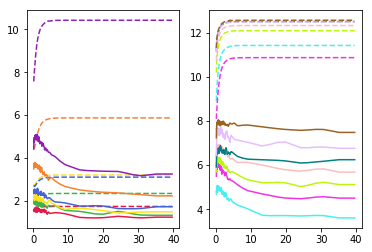

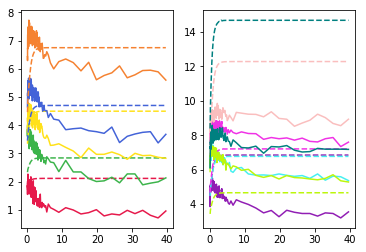

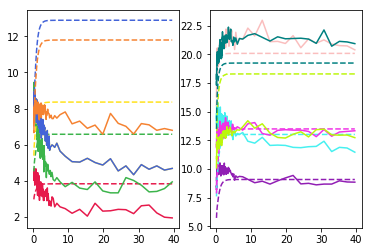

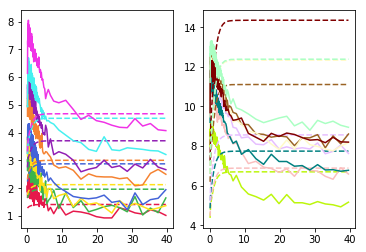

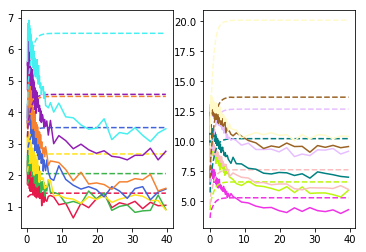

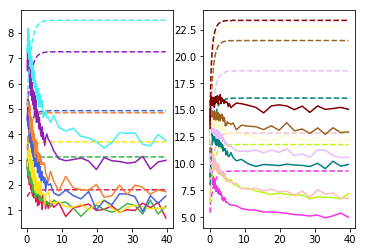

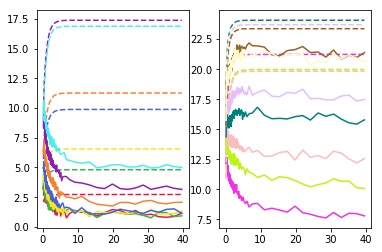

In [61]:
params = params_med
#params = np.array([8.886492e+00, 7.924280e+00, 1.050516e+01, 7.397941e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00, -6.585027e+00, 1.10000e-03, -3.900000e-01])
print(params)

for bt in ['A','B','C','D','E','F','G']:
    #bt='A'
    batch_ids = {'A':[0,13,'A'],'B':[13,24,'B'],'C':[24,35,'C'],'D':[35,51,'D'],'E':[51,65,'E'],'F':[65,80,'F'],'G':[80,94,'G'], 'Whole': [0,94,'Whole']}
    bt_min, bt_max, nn = batch_ids[bt][0], batch_ids[bt][1], batch_ids[bt][2]


    colors  = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',, '#000000']

    sims = np.asarray(simulator(params, seed, simulator_args, 0))[bt_min:bt_max]
    data = np.asarray(faasSimulator.data()[bt_min:bt_max,:])


    # print(compressor(sims, compressor_args))
    # print(compressor(data, compressor_args))

    fig,ax = plt.subplots(1,2) 

    for i in range(len(sims) // 2 ):
        ax[0].plot(time, data[i,:] , color = colors[i])
        ax[0].plot(time, sims[i,:] , '--', color = colors[i])

    for i in range(len(sims) // 2, len(sims)):
        ax[1].plot(time, data[i] , color = colors[i])
        ax[1].plot(time, sims[i] , '--', color = colors[i])

    plt.savefig('batch_' + bt + '_mde.pdf')

In [ ]:
pst = np.unique(pst, axis=0)
pst1 = pst[np.abs(pst[:,0]) < 13] #Discard any obviously wrong samples (write better func to do this)
print(pst1.shape)

## Rank fits


In [ ]:
errors = (np.square(sims - data)).mean(ax=0)
print(errors)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


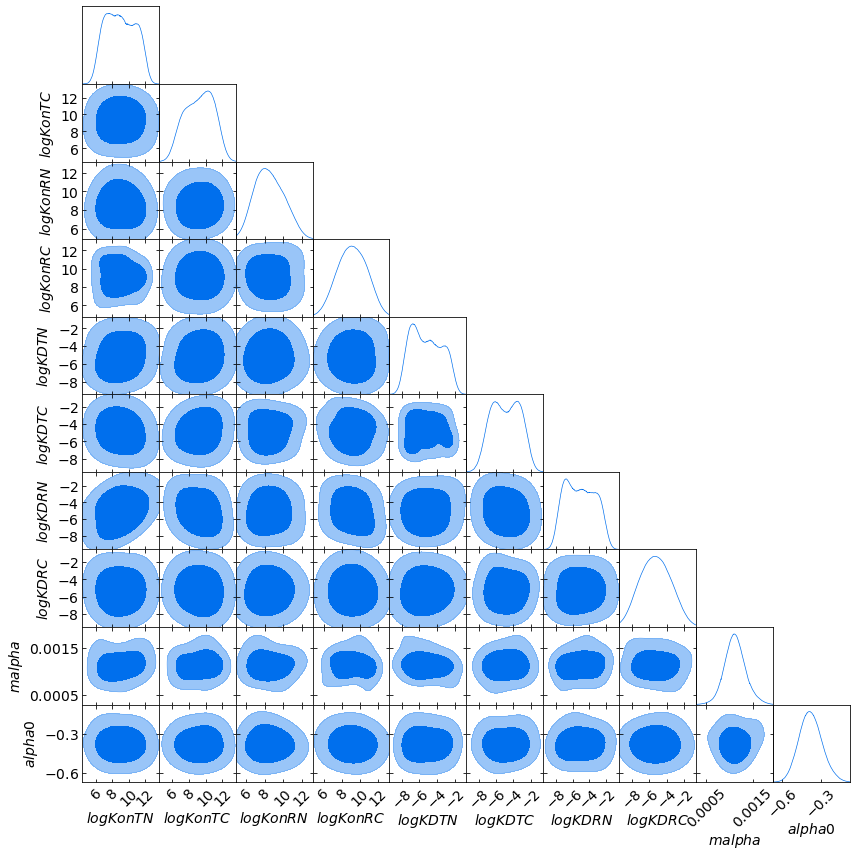

In [62]:
DelfiEnsemble.triangle_plot(samples=[pst], savefig=True, filename='batch_' + let + '_batches.pdf')

## Calibration

In [ ]:
sequential_nsims = [100,200,300,400,500,600,700,800,900,1000,1100]
stacked_sequential_training_loss = [110,-50,-250,-200,-390,-445,-175,-525,-585,-570,-575]
stacked_sequential_training_loss = [110,210,15,-20,-220,-376,-1,-525,-585,-570,-575]

columnwidth = 18 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
with mpl.rc_context({'figure.figsize': [width, width / aspect],
                        'backend': 'pdf',
                        'font.size': 15,
                        'legend.fontsize': 15,
                        'legend.frameon': False,
                        'legend.loc': 'best',
                        'lines.markersize': 3,
                        'lines.linewidth': .5,
                        'axes.linewidth': .5,
                        'axes.edgecolor': 'black'}):

    # Trace plot of the training and validation loss as a function of the number of simulations ran
    plt.plot(sequential_nsims, stacked_sequential_training_loss, markersize=5, marker='o', lw=2, alpha=0.7, label = 'training loss')
    plt.plot(sequential_nsims, stacked_sequential_validation_loss, markersize=5, marker='o', lw=2, alpha=0.7, label = 'validation loss')

    plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
    plt.ylabel(r'negative log loss, $-\mathrm{ln}\,U$')
    plt.tight_layout()
    plt.legend()

plt.savefig('seq_train_loss.pdf')

In [ ]:
# rank = np.zeros(10,9)

# for i in range(N):
#     ps = prior.draw()
#     sims = simulator(ps, 0, simulator_args, 1)
#     DelfiEnsemble = delfi.Delfi(sims, prior, NDEs, 
#                        param_limits = [lower, upper],
#                        param_names = ['logK_on_TN', 'logK_on_TC', 'logK_on_RN', 'logK_on_RC', 'logK_D_TN', 'logK_D_TC', 'logK_D_RN', 'logK_D_RC', 'm_alpha', 'alpha0'],
#                        results_dir = "simulators/faas/calib/", save = False)

    
    
#     n_initial = 100
#     n_batch = 10
#     n_populations = 1

#     DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=2., save_intermediate_posteriors=False, simulator_args=simulator_args)
#     pst = DelfiEnsemble.emcee_sample()[:9]
#     for j in range(10):
#         for l in range(9):
#             rank[j,l] += np.sum(pst[l][j] < ps[j])
#        
# for i in range(10):   
#     plt.hist(rank[i], 10, density = True)
#     plt.show()
#
